# 0. IMPORTS

In [1]:
import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as SS
from boruta import BorutaPy
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor as xgboost

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error 

from kaggle.api.kaggle_api_extended import KaggleApi
import warnings
from os import remove
from zipfile import ZipFile
from random import sample
import pickle

## 0.1. Helper Functions

In [2]:
def cross_val(cv_train, K, model, name = 'n/a', verbose = False):

    result_pd = pd.DataFrame([])
    result_mean = pd.DataFrame([])
    result_std = pd.DataFrame([])
    for k in reversed(range(1, K + 1)):
    
        if verbose == True: print("Starting Fold {}".format(K - k + 1));
        
        # Date filter for validation
        validation_start_date = cv_train['Date'].max() - datetime.timedelta(days = 42 * k)
        validation_end_date = cv_train['Date'].max() - datetime.timedelta(days = 42 * (k - 1))
    
        # Setting Train and Validation sets
        train = cv_train[cv_train['Date'] < validation_start_date]
        val = cv_train[(cv_train['Date'] >= validation_start_date) & (cv_train['Date'] <= validation_end_date)]

        xtrain = train.drop(['Date', 'Sales'], axis = 1)
        ytrain = train['Sales']

        xval = val.drop(['Date', 'Sales'], axis = 1)
        yval = val['Sales']

        # Model processing
        model.fit(xtrain, ytrain)
        y_hat = model.predict(xval)

        # Evaluation
        result = ml_error(np.expm1(yval), np.expm1(y_hat), name)

        result_pd = pd.concat([result_pd, result], axis = 0)

        
    if verbose == True: print(result_pd)    
    
    # Output
    result_mean = result_pd.mean()
    result_std = result_pd.std()

    dictionary = {'MAE' : '{:,.2f} +/- {:,.2f}'.format(result_mean['MAE'], result_std['MAE']),
                  'MAPE': '{:,.2f} +/- {:,.2f}'.format(result_mean['MAPE'], result_std['MAPE']),
                  'RMSE': '{:,.2f} +/- {:,.2f}'.format(result_mean['RMSE'], result_std['RMSE']),
                  'MPE' : '{:,.2f} +/- {:,.2f}'.format(result_mean['MPE'], result_std['MPE'])}

    return pd.DataFrame(dictionary, index = [name])



def mean_percentage_error(y, y_hat):
    error = np.mean((y - y_hat)/y)
    
    return error



def ml_error(y, y_hat, name = "n/a"):
    MAE = mean_absolute_error(y, y_hat)
    MAPE = mean_absolute_percentage_error(y, y_hat)
    RMSE = mean_squared_error(y, y_hat) ** 0.5
    MPE = mean_percentage_error(y, y_hat)
    
    dictionary = {'MAE'      : MAE ,
                  'MAPE'     : MAPE,
                  'RMSE'     : RMSE,
                  'MPE'      : MPE  }
     
    return pd.DataFrame(dictionary, index = [name])



def cramer_v(df1, df2):  
    confusion_matrix = pd.crosstab(df1, df2).values
    chi2 = SS.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

## 0.2. Basic Settings

In [3]:
warnings.filterwarnings('ignore')
seed = 0

## 0.3. Loading Data

In [4]:
kaggle = KaggleApi()
kaggle.authenticate()

kaggle.competition_download_file('rossmann-store-sales', 'train.csv');
kaggle.competition_download_file('rossmann-store-sales', 'store.csv');

with ZipFile('train.csv.zip', 'r') as Zip:
    Zip.extractall()
    
df0_1 = pd.read_csv('train.csv')
df_store_raw = pd.read_csv('store.csv')

remove('train.csv')
remove('train.csv.zip')
remove('store.csv')

100%|█████████████████████████████████████████████████████████████████████████████| 6.71M/6.71M [00:00<00:00, 22.7MB/s]


100%|█████████████████████████████████████████████████████████████████████████████| 44.0k/44.0k [00:00<00:00, 22.6MB/s]

In [5]:
df_raw = df0_1.merge(df_store_raw, how = 'left', on = 'Store')

# 1. DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
df1.columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 
               'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
               'StoreType', 'Assortment', 'CompetitionDistance',
               'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
               'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 
               'PromoInterval'                                         ]

## 1.2. Data Dimensions

In [8]:
print("Number of Rows: {}".format(df1.shape[0]))
print("Number of Columns: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [9]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [10]:
df1.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## 1.4. Check NA

In [11]:
df1.isna().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
dtype: int64

## 1.5. Fillout NA

In [12]:
# CompetitionDistance    
df1['CompetitionDistance'] = df1['CompetitionDistance'].fillna(250000)

# CompetitionOpenSinceMonth 
df1['CompetitionOpenSinceMonth'] = df1.apply(lambda x: x['Date'].month if np.isnan(x['CompetitionOpenSinceMonth']) else x['CompetitionOpenSinceMonth'], axis = 1)

# CompetitionOpenSinceYear   
df1['CompetitionOpenSinceYear'] = df1.apply(lambda x: x['Date'].year if np.isnan(x['CompetitionOpenSinceYear']) else x['CompetitionOpenSinceYear'], axis = 1)
           
# Promo2SinceWeek      
df1['Promo2SinceWeek'] = df1.apply(lambda x: x['Date'].weekofyear if np.isnan(x['Promo2SinceWeek']) else x['Promo2SinceWeek'], axis = 1)

# Promo2SinceYear              
df1['Promo2SinceYear'] = df1.apply(lambda x: x['Date'].year if np.isnan(x['Promo2SinceYear']) else x['Promo2SinceYear'], axis = 1)

# PromoInterval                
df1['PromoInterval'] = df1['PromoInterval'].fillna(0)

## 1.6. Change Data Types

In [13]:
# CompetitionOpenSinceMonth  
df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype(np.int64)

# CompetitionOpenSinceYear            
df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype(np.int64)

# Promo2SinceWeek                   
df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype(np.int64)

# Promo2SinceYear                   
df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype(np.int64)


MonthDict = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['MonthDict'] = df1['Date'].dt.month.map(MonthDict)

df1['IsPromo'] = df1[['PromoInterval', 'MonthDict']].apply(lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['MonthDict'] in x['PromoInterval'].split(',') else 0, axis=1)

df1['StateHoliday'] = df1['StateHoliday'].apply(lambda x: 0 if x == '0' else x)

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
# Central Tendency
means = pd.DataFrame(num_attributes.apply(np.mean)).T
medians = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
stds = pd.DataFrame(num_attributes.apply(np.std)).T
skews = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtoses = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
maxima = pd.DataFrame(num_attributes.apply(max)).T
minima = pd.DataFrame(num_attributes.apply(min)).T
value_range = pd.DataFrame(num_attributes.apply(lambda x: max(x) - min(x))).T

In [16]:
stats = pd.concat([minima, maxima, value_range, means, medians, stds, skews, kurtoses]).T
stats.columns = ["Min", "Max", "Range", "Mean", "Median", "Std", "Skew", "Kurtosis"]
stats

,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
Store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
DayOfWeek,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
Sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
Customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
Open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
Promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
SchoolHoliday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
CompetitionDistance,20.0,250000.0,249980.0,6065.307828,2330.0,14639.818286,12.406761,198.365569
CompetitionOpenSinceMonth,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
CompetitionOpenSinceYear,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [17]:
cat_attributes.describe().T

,count,unique,top,freq
StateHoliday,1017209,4,0,986159
StoreType,1017209,4,a,551627
Assortment,1017209,3,a,537445
PromoInterval,1017209,4,0,508031
MonthDict,1017209,12,May,103695


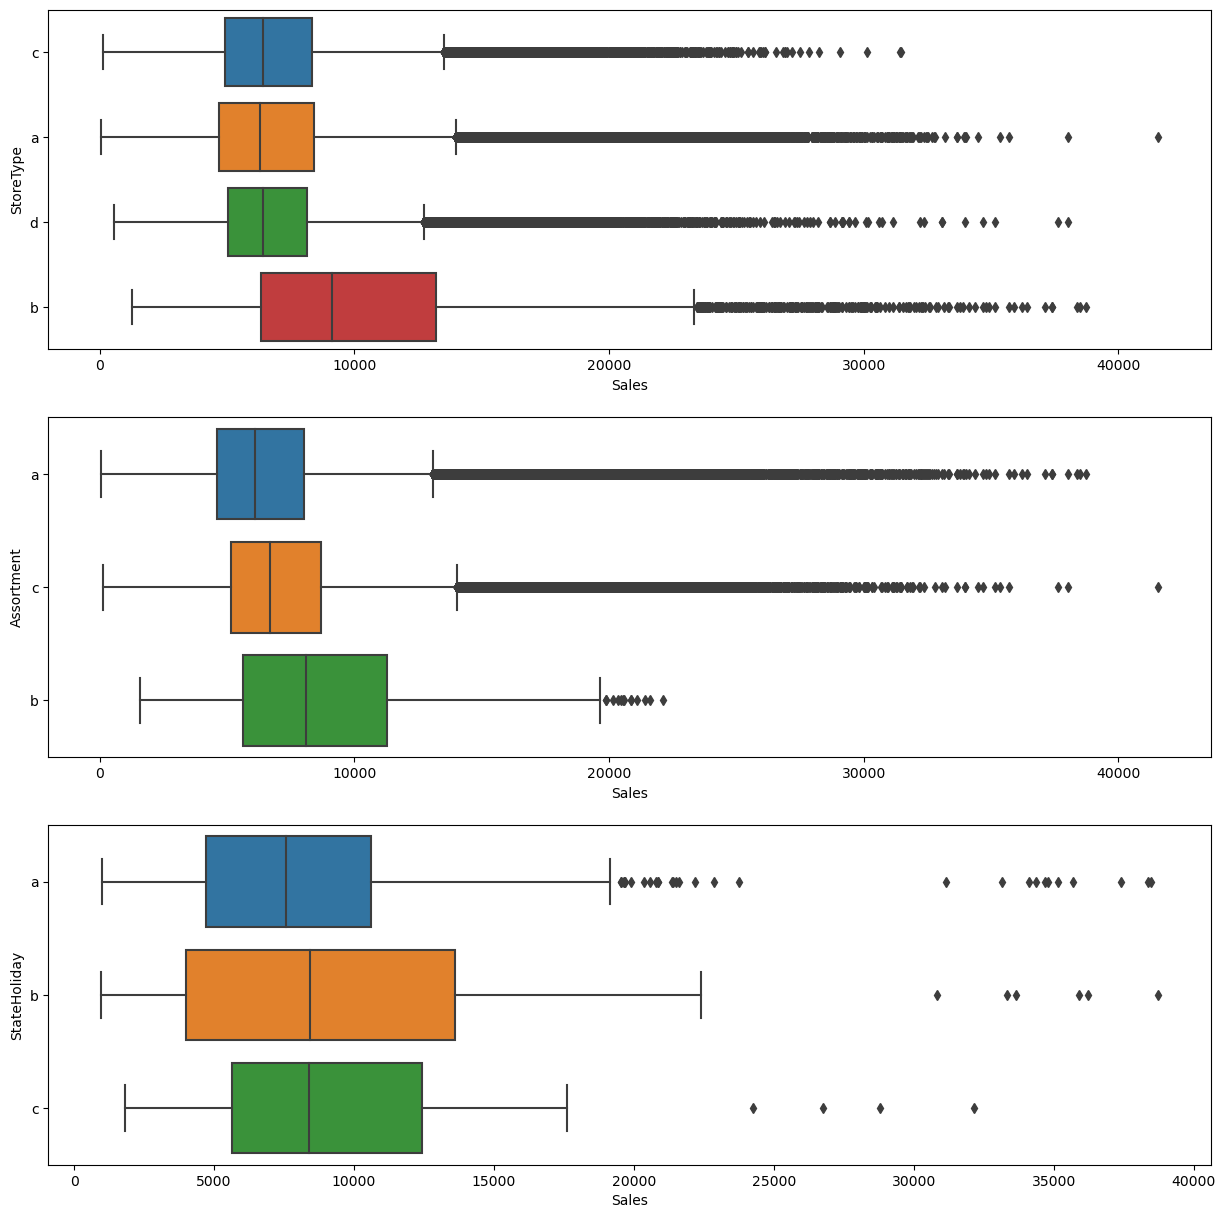

In [18]:
aux = df1[(df1['Sales'] > 0)]

plt.figure(figsize = [15, 15])

plt.subplot(3, 1, 1)
sns.boxplot(x = 'Sales', y = 'StoreType', data = aux)

plt.subplot(3, 1, 2)
sns.boxplot(x = 'Sales', y = 'Assortment', data = aux)

plt.subplot(3, 1, 3)
aux = df1[(df1['StateHoliday'] != 0) & (df1['Sales'] > 0)]
sns.boxplot(x = 'Sales', y = 'StateHoliday', data = aux);

# 2. FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1. Hypoteses

**1.** Stores should sell more when they are in promotion;

**2.** Stores should sell more when they are far from competitors;

**3.** New competitors around should decrease sales;

**4.** Stores should sell less on state holidays;

**5.** Bigger sales use to happen in a bigger assortment;

**6.** School holidays don't affect sales;

## 2.2. Features

In [20]:
df2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'MonthDict', 'IsPromo'],
      dtype='object')

In [21]:
# DateTimes
df2['Day'] = df2['Date'].dt.day
df2['Month'] = df2['Date'].dt.month
df2['Year'] = df2['Date'].dt.year
df2['WeekOfYear'] = df2['Date'].dt.weekofyear

df2['CompetitionSince'] = df2.apply(lambda x: datetime.datetime(year = x['CompetitionOpenSinceYear'], month = x['CompetitionOpenSinceMonth'], day = 1), axis = 1)
df2["CompetitionDurationMonth"] = df2.apply(lambda x: (x['Date'] - x['CompetitionSince'])/30, axis = 1).apply(lambda x: x.days)

df2['PromoSince'] = df2.apply(lambda x: datetime.date.fromisocalendar(x['Promo2SinceYear'], x['Promo2SinceWeek'], 1), axis = 1)
df2['PromoSince'] = pd.to_datetime(df2['PromoSince'])
df2['PromoDurationWeek'] = df2.apply(lambda x: (x["Date"] - x['PromoSince']) / 7, axis = 1).apply(lambda x: x.days)

# State Holiday
holidays_dict = {'a': 'Public', 'b': 'Easter', 'c': 'Christmas', 0: 'Regular'}
df2['StateHoliday'] = df2['StateHoliday'].map(holidays_dict)

# Assortment
assortment_dict = {'a': 'Basic', 'b': 'Extra', 'c': 'Extended'}
df2['Assortment'] = df2['Assortment'].map(assortment_dict)

# 3. VARIABLE FILTERING

In [22]:
df3 = df2.copy()

## 3.1. Row Filtering

In [23]:
df3 = df3[(df3['Sales'] > 0) & df3["Open"] == 1]

## 3.2. Columns Filtering

In [24]:
cols2drop = ['Customers', 'MonthDict', 'PromoInterval', 'Open']
df3.drop(cols2drop, axis = 1, inplace = True)

# 4. EXPLORATORY DATA ANALYSIS (EDA)

In [25]:
df4 = df3.copy()

In [26]:
num_attr_df4 = df4.select_dtypes(include = ['int64', 'float64'])
cat_attr_df4 = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

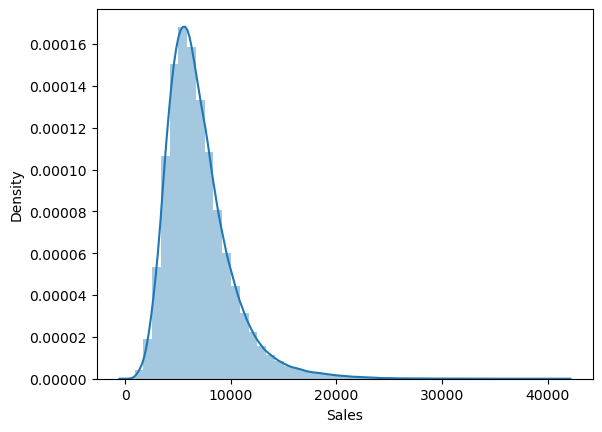

In [27]:
sns.distplot(df4['Sales']);

### 4.1.2. Numerical Attributes

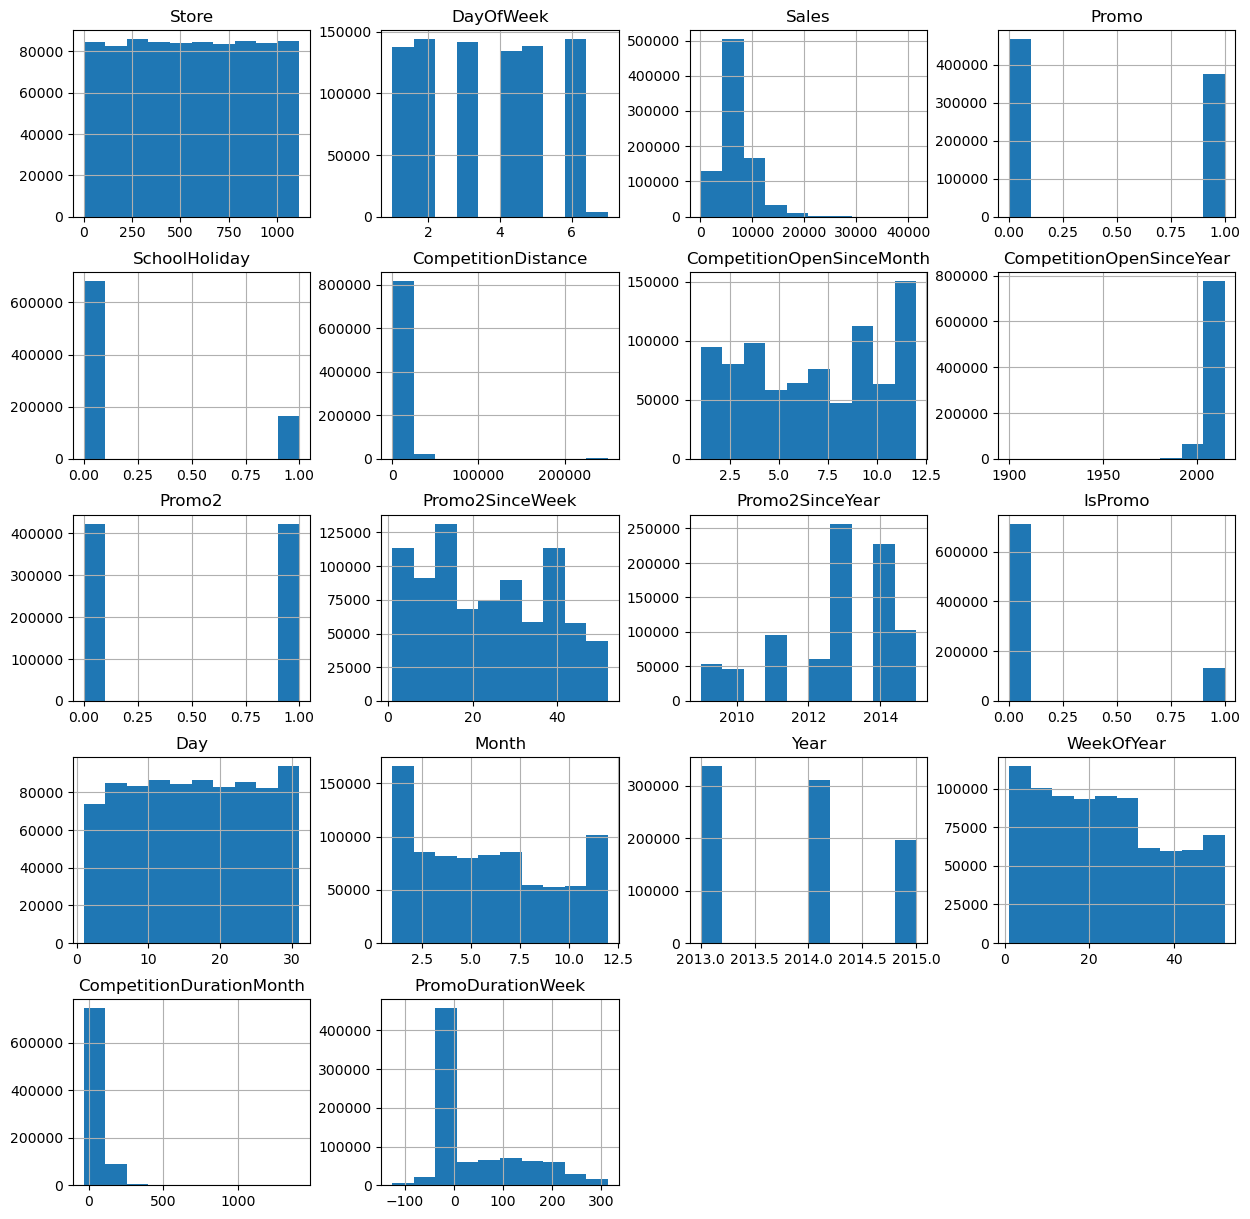

In [28]:
num_attr_df4.hist(figsize = [15, 15]);

### 4.1.3. Categorical Attributes

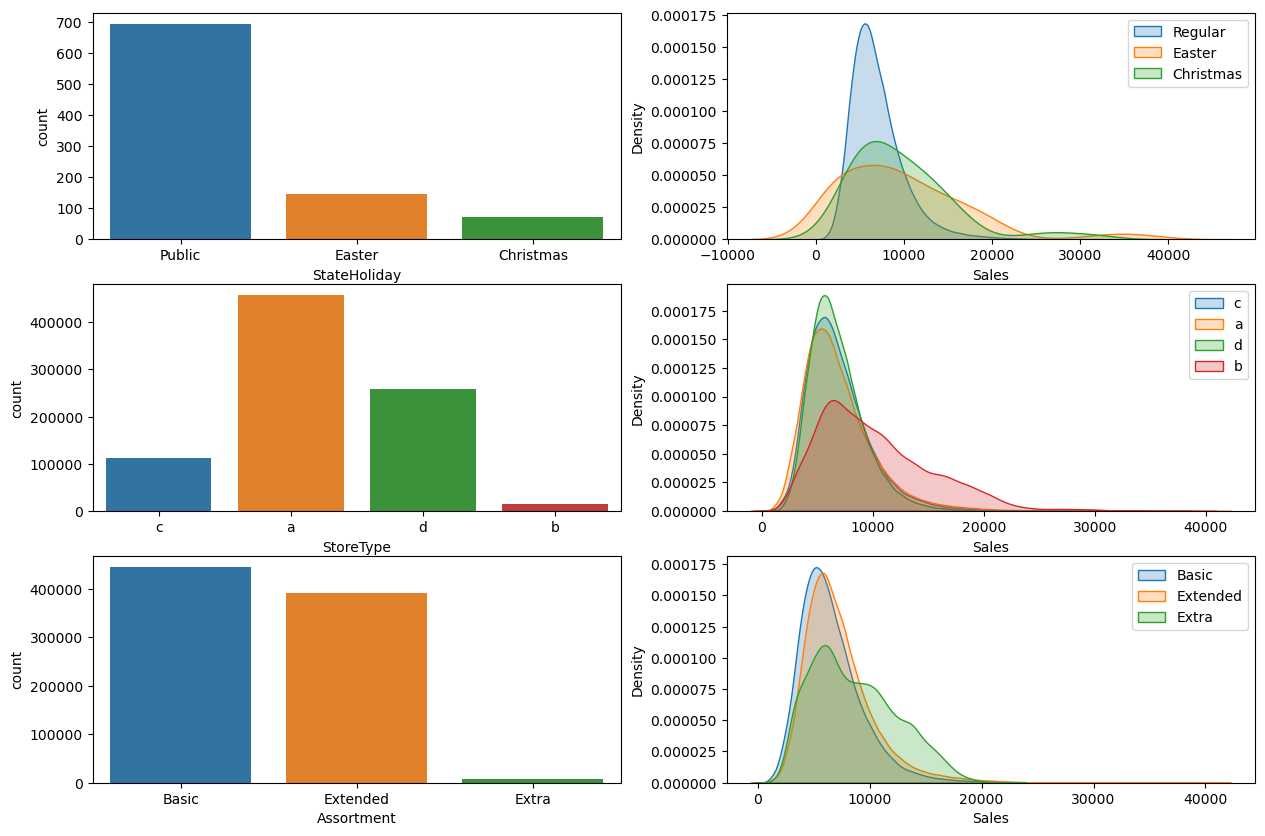

In [29]:
plt.figure(figsize = [15, 10])

# StateHoliday
plt.subplot(3, 2, 1)
sns.countplot(x = 'StateHoliday', data = df4[df4['StateHoliday'] != "Regular"])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['StateHoliday'] == "Regular"]['Sales'], shade = True)
sns.kdeplot(df4[df4['StateHoliday'] == "Easter"]['Sales'], shade = True)
sns.kdeplot(df4[df4['StateHoliday'] == "Christmas"]['Sales'], shade = True)
plt.legend(["Regular", "Easter", "Christmas"])


# StoreType
plt.subplot(3, 2, 3)
sns.countplot(x = 'StoreType', data = df4)

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['StoreType'] == "c"]['Sales'], shade = True)
sns.kdeplot(df4[df4['StoreType'] == "a"]['Sales'], shade = True)
sns.kdeplot(df4[df4['StoreType'] == "d"]['Sales'], shade = True)
sns.kdeplot(df4[df4['StoreType'] == "b"]['Sales'], shade = True)
plt.legend(['c', 'a', 'd', 'b'])


# Assortment
plt.subplot(3, 2, 5)
sns.countplot(x = 'Assortment', data = df4)

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['Assortment'] == "Basic"]['Sales'], shade = True)
sns.kdeplot(df4[df4['Assortment'] == "Extended"]['Sales'], shade = True)
sns.kdeplot(df4[df4['Assortment'] == "Extra"]['Sales'], shade = True)
plt.legend(['Basic', 'Extended', "Extra"]);

## 4.2. Bivariate Analysis

### H1. Stores should sell more when they are in promotion.
**False:** There is no statistical evidence that promotions raise sales

In [30]:
aux = df4[df4['IsPromo'] == 0].groupby('Store').mean()[['Sales']]
aux2 = df4[df4['IsPromo'] == 1].groupby('Store').mean()[['Sales']]
aux = aux.loc[aux2.index]

SS.ttest_ind(aux, aux2)

Ttest_indResult(statistic=array([0.40131258]), pvalue=array([0.68826521]))

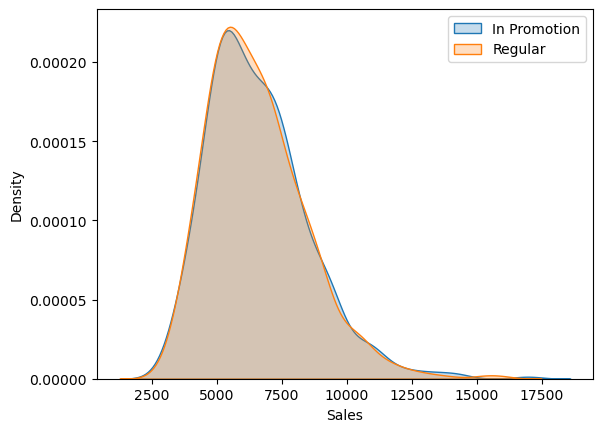

In [31]:
sns.kdeplot(x = 'Sales', data = aux, shade = True);
sns.kdeplot(x = 'Sales', data = aux2, shade = True);
plt.legend(['In Promotion', 'Regular']);

In [32]:
aux = df4.copy()
aux['Sales'] = df4.apply(lambda x: x['Sales'] if x["IsPromo"] else - x['Sales'], axis = 1)
aux2 = aux.groupby(["Store", "IsPromo"]).mean()['Sales']
aux2 = aux2.groupby('Store').sum()

stores = aux[aux['IsPromo'] == 1]['Store'].unique()
aux2 = aux2.loc[stores]

print('Mean: {:.2f}\tMedian: {:.2f}\tSkew: {:.2f}'.format(aux2.mean(), aux2.median(), aux2.skew()))

Mean: -45.73	Median: -97.60	Skew: 0.77


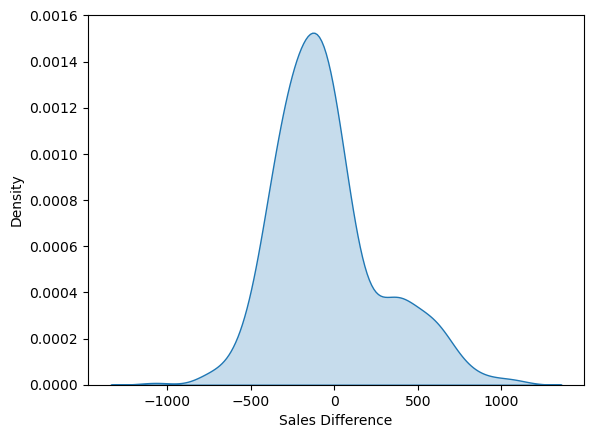

In [33]:
sns.kdeplot(x = aux2, shade = True)
plt.xlabel('Sales Difference');

### H2. Stores should sell more when they are far from competitors.
**False:** There is no such a correlation between those variables.

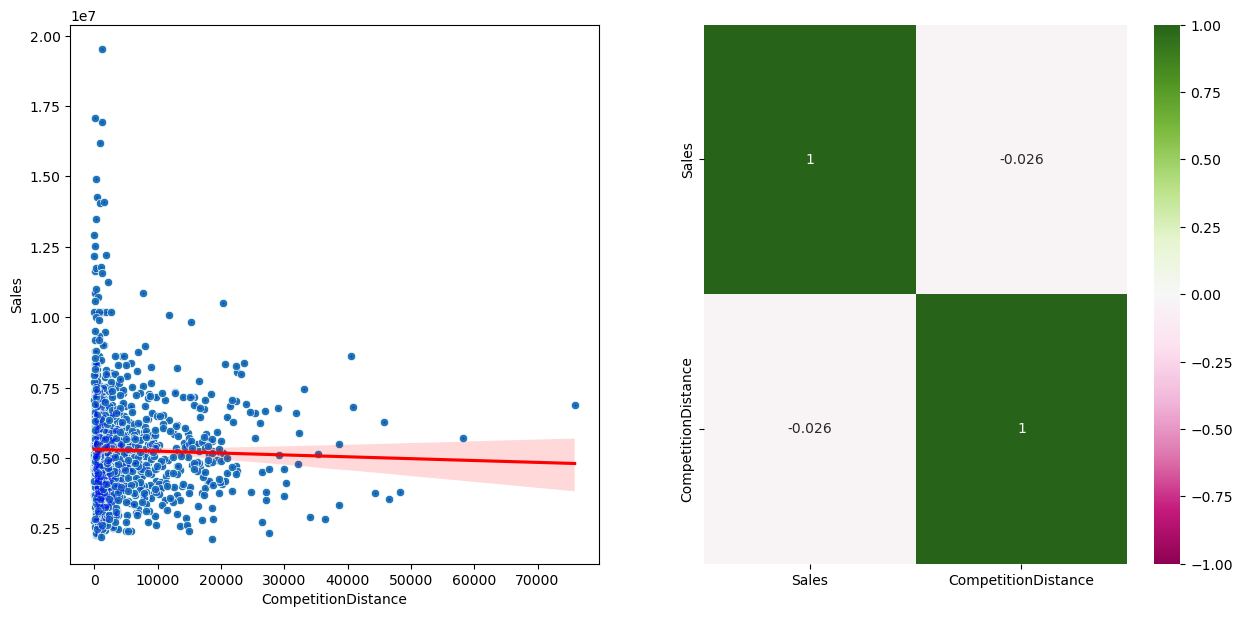

In [34]:
aux = df4.groupby("Store").sum()[["Sales"]]
aux2 = df4.groupby("Store").min()[['CompetitionDistance']]
aux = aux.join(aux2, how = 'left', on = "Store")

aux = aux[aux['CompetitionDistance'] < 100000]


plt.figure(figsize = [15, 7])

plt.subplot(1, 2, 1)
sns.scatterplot(x = 'CompetitionDistance', y = "Sales", data = aux)
sns.regplot(x = 'CompetitionDistance', y = "Sales", data = aux,  scatter_kws={"color": "blue", 's': 0.1}, line_kws={"color": "red"})

plt.subplot(1, 2, 2)
sns.heatmap(aux.corr(), cmap = "PiYG" , vmin = -1, vmax = 1, annot = True);

### H3. New competitors around should decrease sales.
**False:** New competitors raise sales.

Global Maximum of 1,856,418,182 at month 0.


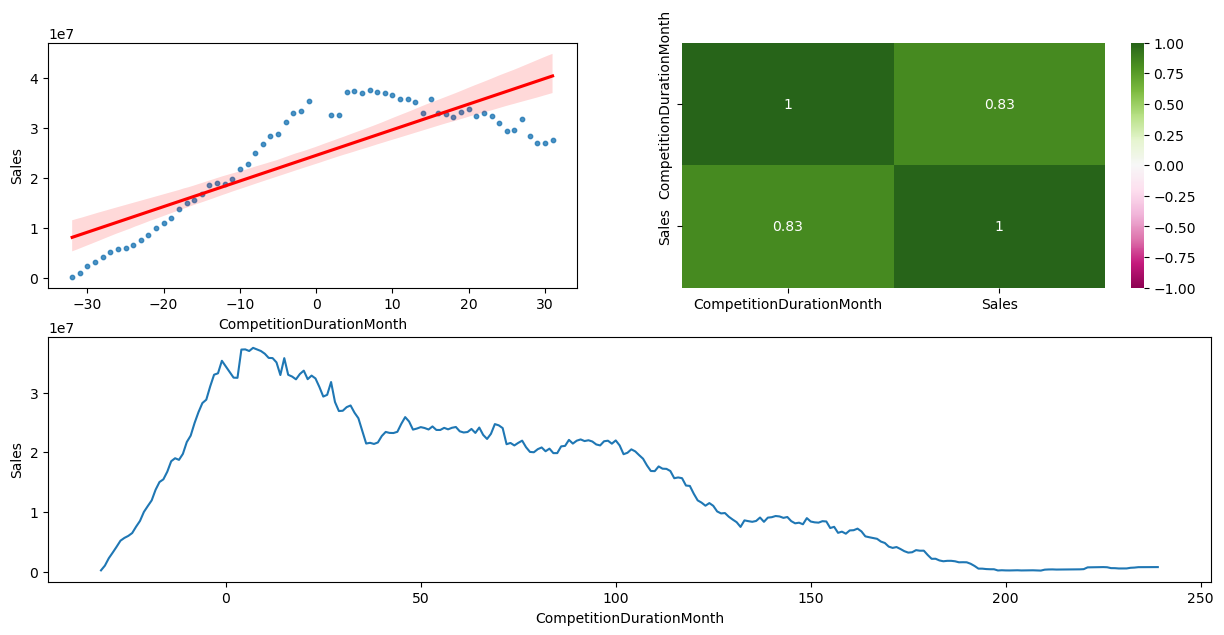

In [35]:
aux = df4.groupby('CompetitionDurationMonth').sum()['Sales'].reset_index()
global_max = aux.max()['Sales']
month_max = aux.where(aux['Sales'] == global_max).dropna()['CompetitionDurationMonth'].iloc[0]

aux = aux[aux['Sales'] < 6e7]
aux2 = aux.copy()
aux2 = aux2[aux2['CompetitionDurationMonth'] < 240]
aux = aux[aux['CompetitionDurationMonth'] < 32]


plt.figure(figsize = [15, 7])

plt.subplot(2, 2, 1)
sns.regplot(x = 'CompetitionDurationMonth', y = 'Sales', data = aux, scatter_kws = {'s': 10}, line_kws = {'color': 'red'});

plt.subplot(2, 2, 2)
sns.heatmap(aux.corr(), cmap = 'PiYG', annot = True, vmin = -1, vmax = 1)

plt.subplot(2, 1, 2)
sns.lineplot(x = 'CompetitionDurationMonth', y = 'Sales', data = aux2);

print('Global Maximum of {:,.0f} at month {:.0f}.'.format(global_max, month_max))

### H4. Stores should sell less on state holidays.
**????:** This hypothesis cannot be confirmed nor denied.

In [36]:
aux = df4[df4['StateHoliday'] == 'Regular'].groupby("Store").mean()[['Sales']]
aux2 = df4[df4['StateHoliday'] != 'Regular'].groupby("Store").mean()[['Sales']]
aux = aux.loc[aux2.index]

SS.ttest_ind(aux, aux2)

Ttest_indResult(statistic=array([0.42552364]), pvalue=array([0.67075024]))

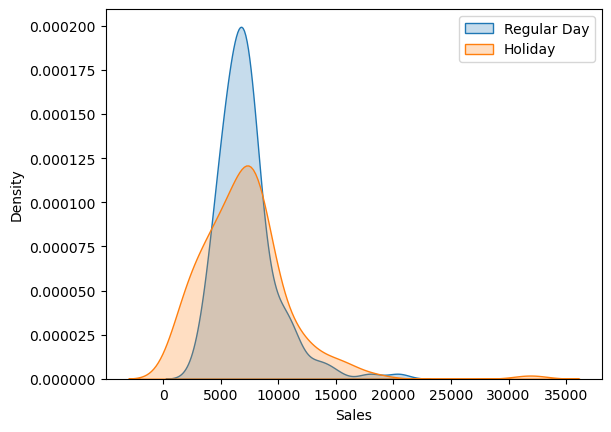

In [37]:
sns.kdeplot(x = 'Sales', data = aux, shade = True)
sns.kdeplot(x = 'Sales', data = aux2, shade = True)
plt.legend(["Regular Day", "Holiday"]);

### H5. Bigger sales use to happen in a bigger assortment.
**False:** Bigger sales are more often in "Extra" assortments.

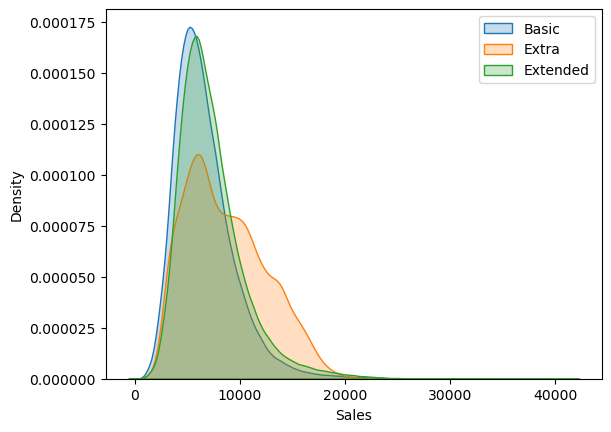

In [38]:
sns.kdeplot(df4[df4['Assortment'] == "Basic"]['Sales'], shade = True)
sns.kdeplot(df4[df4['Assortment'] == "Extra"]['Sales'], shade = True)
sns.kdeplot(df4[df4['Assortment'] == "Extended"]['Sales'], shade = True)

plt.legend(['Basic', 'Extra', "Extended"]);

### H6. School holidays don't affect sales.
**False:** School holidays raise sales.

In [39]:
aux = df4[df4['SchoolHoliday'] == 0].groupby('Store').mean()[['Sales']]
aux2 = df4[df4['SchoolHoliday'] == 1].groupby('Store').mean()[['Sales']]

SS.ttest_ind(aux.values, aux2.values)

Ttest_indResult(statistic=array([-2.77510752]), pvalue=array([0.00556441]))

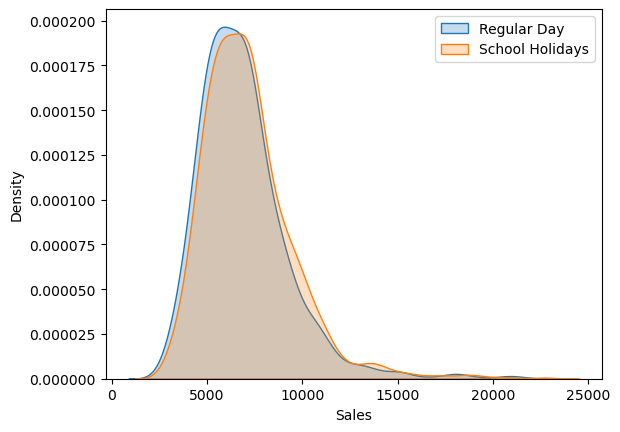

In [40]:
sns.kdeplot(x = 'Sales', data = aux, shade = True)
sns.kdeplot(x = 'Sales', data = aux2, shade = True)
plt.legend(["Regular Day", "School Holidays"]);

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

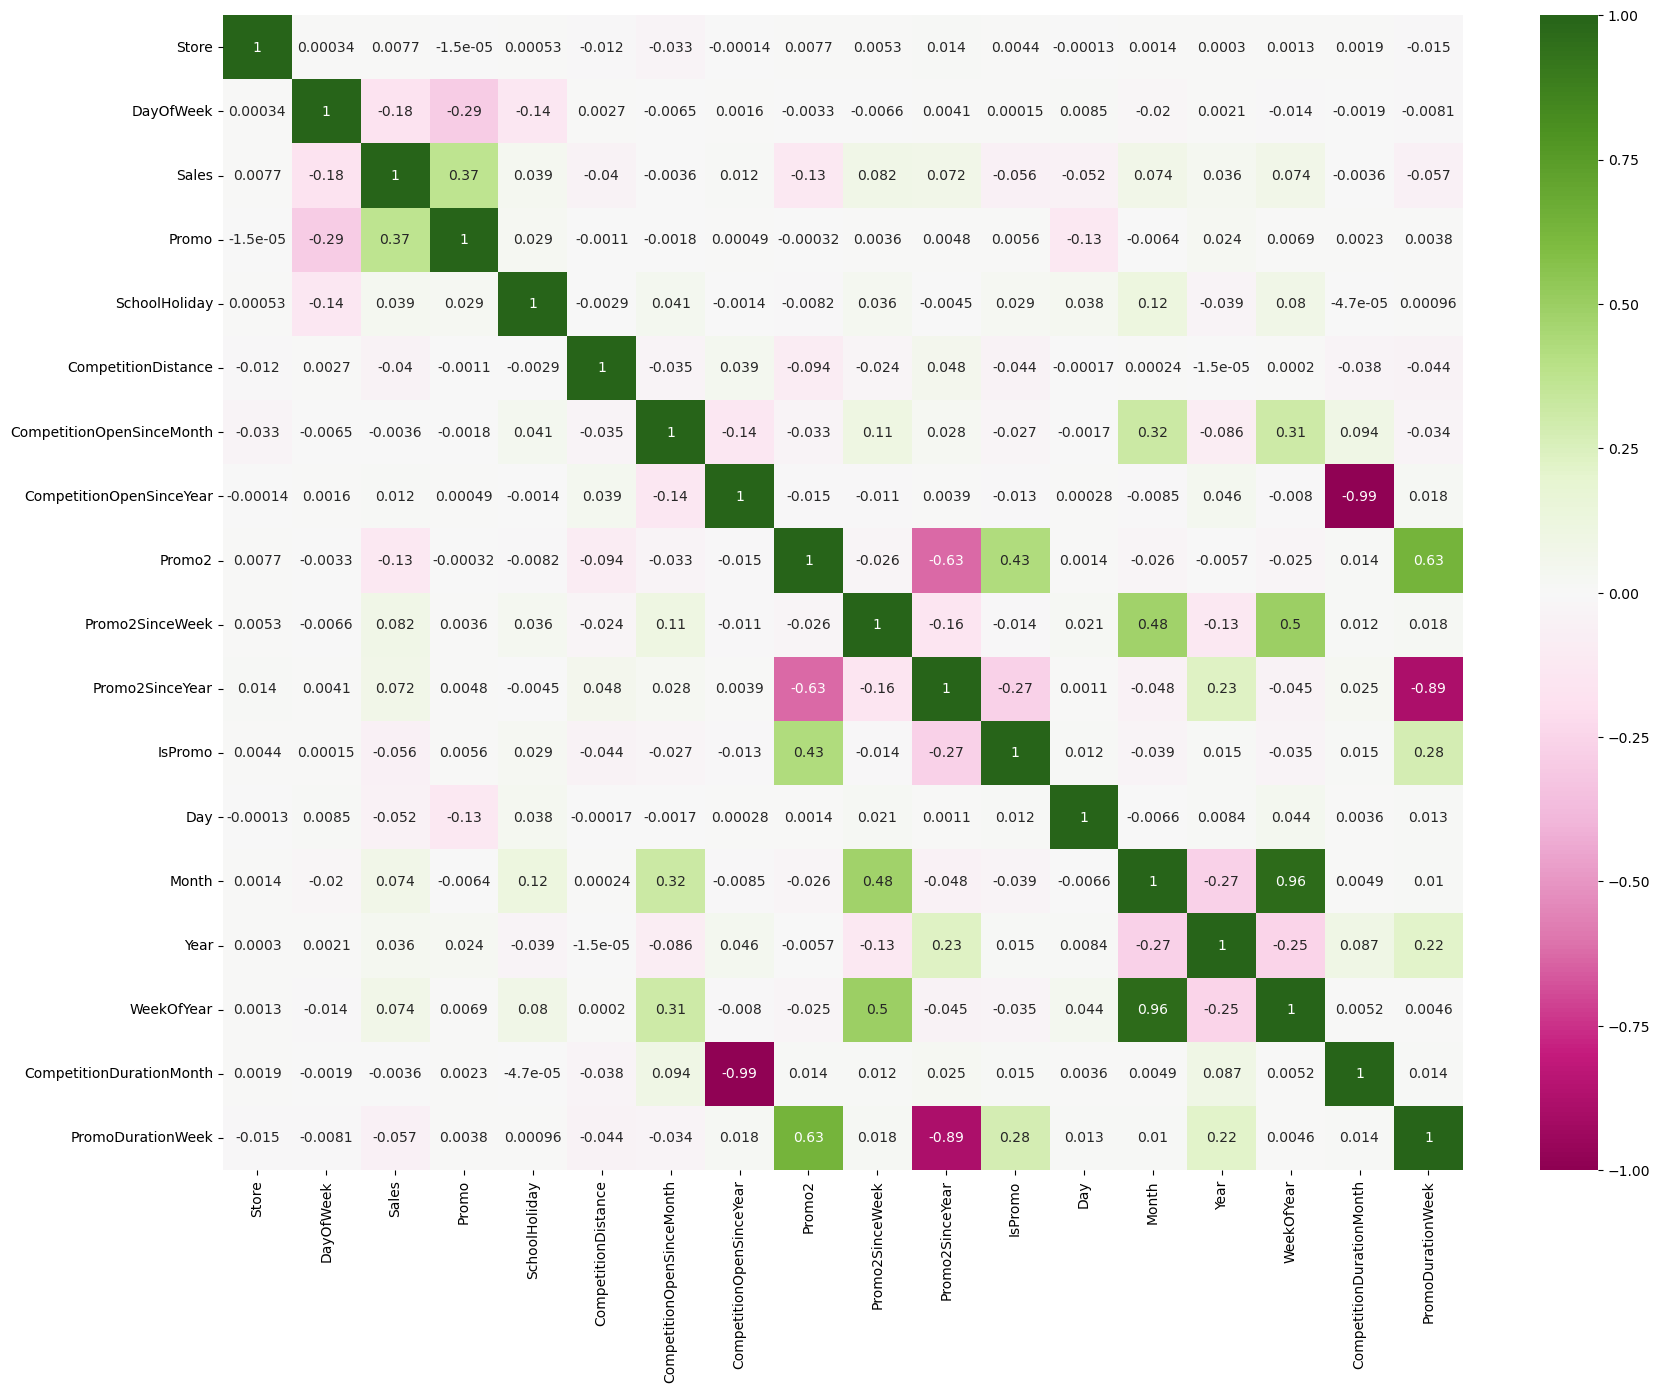

In [41]:
plt.figure(figsize = [20, 15])
sns.heatmap(num_attr_df4.corr(), annot = True, vmin = -1, vmax = 1, cmap = "PiYG");

### 4.3.2. Categorical Attributes

In [42]:
L = cat_attr_df4.shape[1]
cat_corr = pd.DataFrame(np.zeros([L, L]), columns = cat_attr_df4.columns, index = cat_attr_df4.columns)
for i in cat_attr_df4.columns:
    for j in cat_attr_df4.columns:
        cat_corr.loc[i, j] = cramer_v(df4[i], df4[j])

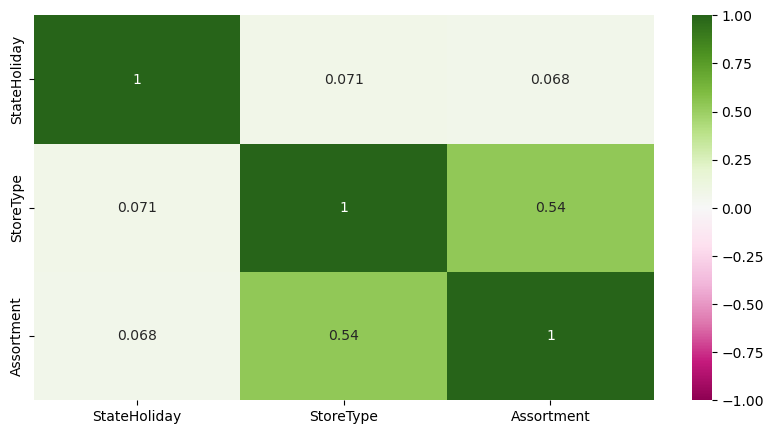

In [43]:
plt.figure(figsize = [10, 5])
sns.heatmap(cat_corr, annot = True, vmin = -1, vmax = 1, cmap = "PiYG");

# 5. DATA PREPARATION

In [44]:
df5 = df4.copy()
num_attr_df5 = df5.select_dtypes(include = ['int64', 'float64'])
cat_attr_df5 = df5.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

## 5.1. Transformations

### 5.1.1. Encoding

In [45]:
# StateHoliday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['StateHoliday'], columns=['StateHoliday'])

# StoreType - Label Encoding
le = LabelEncoder()
df5['StoreType'] = le.fit_transform(df5['StoreType'])
pickle.dump(le, open('parameter/StoreType_encoding.pkl', 'wb'))

# Assortment - Ordinal Encoding
assortment_dict = {'Basic': 1, 'Extra': 2, 'Extended': 3}
df5['Assortment'] = df5['Assortment'].map( assortment_dict)

### 5.1.2. Response Variable Transformation

In [46]:
df5['Sales'] = np.log1p( df5['Sales'] )

### 5.1.3. Nature Transformation

In [47]:
# Day Of Week
df5['DayOfWeek_sin'] = df5['DayOfWeek'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['DayOfWeek_cos'] = df5['DayOfWeek'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# Month
df5['Month_sin'] = df5['Month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['Month_cos'] = df5['Month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# Day
df5['Day_sin'] = df5['Day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['Day_cos'] = df5['Day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# Week Of Year
df5['WeekOfYear_sin'] = df5['WeekOfYear'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['WeekOfYear_cos'] = df5['WeekOfYear'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

## 5.2. Scaling

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()

# Competition Distance
df5['CompetitionDistance'] = rs.fit_transform(df5[['CompetitionDistance']].values)
pickle.dump(rs, open('parameter/CompetitionDistance_scaling.pkl', 'wb'))

# Competition Duration Month
df5['CompetitionDurationMonth'] = rs.fit_transform(df5[['CompetitionDurationMonth']].values)
pickle.dump(rs, open('parameter/CompetitionDuration_scaling.pkl', 'wb'))

# Promo Duration Week
df5['PromoDurationWeek'] = mms.fit_transform(df5[['PromoDurationWeek']].values)
pickle.dump(mms, open('parameter/PromoDuration_scaling.pkl', 'wb'))

# Year
df5['Year'] = mms.fit_transform(df5[['Year']].values)
pickle.dump(mms, open('parameter/Year_scaling.pkl', 'wb'))

# 6. FEATURE SELECTION

In [49]:
df6 = df5.copy()

In [50]:
cols2drop = ["DayOfWeek", 'Month', 'Day', 'WeekOfYear', 'PromoSince', "CompetitionSince"]
df6.drop(cols2drop, axis = 1, inplace = True)

## 6.1. Data Splitting

In [51]:
# Train
X_train = df6[df6['Date'] < '2015-06-19']
y_train = X_train['Sales']

# Test
X_test = df6[df6['Date'] >= '2015-06-19']
y_test = X_test['Sales']

print('Training Min Date: {}'.format(X_train['Date'].min()))
print('Training Max Date: {}'.format(X_train['Date'].max()))
print('Training Interval: {}'.format(X_train['Date'].max() - X_train['Date'].min()))

print('\nTest Min Date: {}'.format( X_test['Date'].min()))
print('Test Max Date: {}'.format(X_test['Date'].max()))
print('Test Interval: {}'.format(X_test['Date'].max() - X_test['Date'].min()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Training Interval: 898 days 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00
Test Interval: 42 days 00:00:00


## 6.2. Boruta as Feature Selector

In [52]:
'''
# training and test dataset for Boruta
X_train_np = X_train.drop(['Date', 'Sales'], axis=1).values
y_train_np = y_train.values.ravel()

# define RandomForestRegressor
rf = RF(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=seed).fit(X_train_np, y_train_np)
'''

"\n# training and test dataset for Boruta\nX_train_np = X_train.drop(['Date', 'Sales'], axis=1).values\ny_train_np = y_train.values.ravel()\n\n# define RandomForestRegressor\nrf = RF(n_jobs=-1)\n\n# define Boruta\nboruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=seed).fit(X_train_np, y_train_np)\n"

### 6.2.1. Best Features Chosen

In [53]:
'''
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['Date', 'Sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta))
'''

"\ncols_selected = boruta.support_.tolist()\n\n# best features\nX_train_fs = X_train.drop(['Date', 'Sales'], axis=1)\ncols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()\n\n# not selected boruta\ncols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta))\n"

## 6.3. Manual Selection

In [54]:
cols_selected = ['Store', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionDurationMonth',
                 'PromoDurationWeek', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
                 'WeekOfYear_sin', 'WeekOfYear_cos']

cols_selected_cv = cols_selected.copy()
cols_selected_cv.extend(['Sales', 'Date'])

# 7. MACHINE LEARNING MODELLING

In [61]:
x_train = X_train[cols_selected]
x_test = X_test[cols_selected]

cv_train = X_train[cols_selected_cv]

## 7.1. Average Model

In [82]:
aux = x_train.copy()
aux['Sales'] = y_train.copy()

# Prediction
pred = aux.groupby("Store").mean()[['Sales']].reset_index().rename(columns = {'Sales': 'Predictions'})
aux2 = x_test.copy()
y_hat_average = aux2.merge(pred, how = 'left', on = 'Store')['Predictions']

# Evaluation

result_average = ml_error(np.expm1(y_test), np.expm1(y_hat_average), 'Average')
result_average

,MAE,MAPE,RMSE,MPE
Average,1429.763326,0.216814,1939.32873,-0.116433


## 7.2. KNN Regressor

### 7.2.1. Single Model

In [83]:
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)
y_hat_knn = knn.predict(x_test)

result_knn = ml_error(np.expm1(y_test), np.expm1(y_hat_knn), 'KNN')
result_knn

,MAE,MAPE,RMSE,MPE
KNN,833.339517,0.121845,1215.49963,0.004525


### 7.2.2. Cross Validation

In [84]:
result_knn_cv = cross_val(cv_train, 5, knn, 'KNN')
result_knn_cv

,MAE,MAPE,RMSE,MPE
KNN,"1,042.18 +/- 270.63",0.14 +/- 0.03,"1,477.50 +/- 359.43",0.02 +/- 0.02


## 7.3. Linear Regression - Ridge Regularization 

### 7.3.1 Single Model

In [85]:
linear_reg = Ridge()
linear_reg.fit(x_train, y_train)
y_hat_linear_reg = linear_reg.predict(x_test)

result_linear_reg = ml_error(np.expm1(y_test), np.expm1(y_hat_linear_reg), 'Linear')
result_linear_reg

,MAE,MAPE,RMSE,MPE
Linear,1866.19595,0.29256,2671.348553,-0.081314


### 7.3.2. Cross Validation

In [86]:
result_linear_reg_cv = cross_val(cv_train, 5, linear_reg, 'Linear Regression')
result_linear_reg_cv

,MAE,MAPE,RMSE,MPE
Linear Regression,"2,081.83 +/- 330.44",0.30 +/- 0.02,"2,953.77 +/- 523.41",-0.06 +/- 0.08


## 7.4. Random Forest

### 7.4.1. Single Model

In [87]:
rf = RF(n_jobs = -1)
rf.fit(x_train, y_train)
y_hat_rf = rf.predict(x_test)

result_rf = ml_error(np.expm1(y_test), np.expm1(y_hat_rf), 'Random Forest')
result_rf

,MAE,MAPE,RMSE,MPE
Random Forest,682.766024,0.100597,1018.367844,-0.020129


### 7.4.2. Cross Validation

In [88]:
result_rf_cv = cross_val(cv_train, 5, rf, 'Random Forest')
result_rf_cv

,MAE,MAPE,RMSE,MPE
Random Forest,837.59 +/- 242.19,0.12 +/- 0.03,"1,255.47 +/- 353.48",0.01 +/- 0.03


## 7.5. XGBoost

### 7.5.1. Single Model 

In [89]:
xgb = xgboost()
xgb.fit(x_train, y_train)
y_hat_xgb = xgb.predict(x_test)

result_xgb = ml_error(np.expm1(y_test), np.expm1(y_hat_xgb), 'XGBoost')
result_xgb

,MAE,MAPE,RMSE,MPE
XGBoost,896.442163,0.134865,1278.811701,-0.022933


### 7.5.2. Cross Validation

In [90]:
result_xgb_cv = cross_val(cv_train, 5, xgb, 'XGBoost')
result_xgb_cv

,MAE,MAPE,RMSE,MPE
XGBoost,"1,059.71 +/- 191.37",0.15 +/- 0.02,"1,520.76 +/- 263.30",0.01 +/- 0.02


## 7.6. Comparing Models Performances

### 7.6.1. Single Model

In [91]:
pd.concat([result_average, result_knn, result_linear_reg, result_rf, result_xgb])

,MAE,MAPE,RMSE,MPE
Average,1429.763326,0.216814,1939.328730,-0.116433
KNN,833.339517,0.121845,1215.499630,0.004525
Linear,1866.195950,0.292560,2671.348553,-0.081314
Random Forest,682.766024,0.100597,1018.367844,-0.020129
XGBoost,896.442163,0.134865,1278.811701,-0.022933


### 7.6.2. Cross Validation

In [92]:
pd.concat([result_knn_cv, result_linear_reg_cv, result_rf_cv, result_xgb_cv])

,MAE,MAPE,RMSE,MPE
KNN,"1,042.18 +/- 270.63",0.14 +/- 0.03,"1,477.50 +/- 359.43",0.02 +/- 0.02
Linear Regression,"2,081.83 +/- 330.44",0.30 +/- 0.02,"2,953.77 +/- 523.41",-0.06 +/- 0.08
Random Forest,837.59 +/- 242.19,0.12 +/- 0.03,"1,255.47 +/- 353.48",0.01 +/- 0.03
XGBoost,"1,059.71 +/- 191.37",0.15 +/- 0.02,"1,520.76 +/- 263.30",0.01 +/- 0.02


# 8. HYPERARAMETERS FINE TUNING

## 8.1. Random Search

In [ ]:
#param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03]                           ,
#         'max_depth': [3, 5, 9]                        ,
#         'subsample': [0.1, 0.5, 0.7]                  ,
#         'colsample_bytree': [0.3, 0.7, 0.9]           ,
#         'min_child_weight': [3, 8, 15]                 }

#evals = 5

#rand_search = RandomizedSearchCV(estimator = xgboost(), param_distributions = param, cv = 5, n_iter = evals, n_jobs = 6, verbose = 3)
#rand_search.fit(x_train, y_train)
#rand_search.best_params_rand_search.best_params_

##  8.2. Final Model

In [ ]:
param_final = {'n_estimators': 3000,
                'eta': 0.03,
                'max_depth': 5,
                'subsample': 0.7,
                'colsample_bytree': 0.7,
                'min_child_weight': 3   }


In [ ]:
model_final = xgboost(n_estimators      = param_final['n_estimators']     ,
                      eta               = param_final['eta']              ,
                      max_depth         = param_final['max_depth']        ,
                      subsample         = param_final['subsample']        ,
                      colsample_bytree  = param_final['colsample_bytree'] ,
                      min_child_weight  = param_final['min_child_weight'] ,
                      random_state      = seed                             )
model_final.fit(x_train, y_train)
y_hat_final = model_final.predict(x_test)

result_final = ml_error(np.expm1(y_test), np.expm1(y_hat_final), 'XGB')

In [103]:
result_final

,MAE,MAPE,RMSE,MPE
XGB,764.775966,0.115128,1098.37981,-0.018111


In [ ]:
pickle.dump(model_final, open(r"C:\Users\Noudy\Desktop\Estudo\rossmann-sales\models\final_model.pkl", 'wb'))

# 9. RESULTS INTERPRETATION

In [97]:
df9 = X_test[cols_selected_cv]

df9['Sales'] = np.expm1(df9['Sales'])
df9['Predictions'] = np.expm1(y_hat_final)

## 9.1. Bussines Performance

In [98]:
aux = df9.groupby("Store").sum()[["Predictions"]].reset_index()

aux_mape = df9[['Sales', 'Store', 'Predictions']].groupby("Store").apply(lambda x: mean_absolute_percentage_error(x['Sales'], x['Predictions'])).reset_index().rename(columns = {0: 'MAPE'})
aux_mae = df9[['Sales', 'Store', 'Predictions']].groupby("Store").apply(lambda x: mean_absolute_error(x['Sales'], x['Predictions'])).reset_index().rename(columns = {0: 'MAE'})

aux2 = pd.merge(aux_mae, aux_mape, how = 'left', on = 'Store')
df9_1 = pd.merge(aux, aux2, how = 'left', on = 'Store')

df9_1['WorstScenario'] = df9_1['Predictions'] - df9_1['MAE']
df9_1['BestScenario'] = df9_1['Predictions'] + df9_1['MAE']

In [ ]:
df9_1.sort_values("MAPE", ascending = False).head()

## 9.2. Total Performance

In [99]:
df9_2 = df9_1[['Predictions', 'WorstScenario', 'BestScenario']].sum().reset_index().rename(columns = {0: 'Values', 'index': 'Scenarios'})
df9_2['Values'] = df9_2["Values"].map("${:,.2f}".format)
df9_2

,Scenarios,Values
0,Predictions,"$286,501,248.00"
1,WorstScenario,"$285,645,345.52"
2,BestScenario,"$287,357,120.66"


## 9.3. Algorithm Performance

In [100]:
df9['Error'] = df9['Sales'] - df9['Predictions']
df9['Error_rate'] = df9['Predictions'] / df9['Sales']

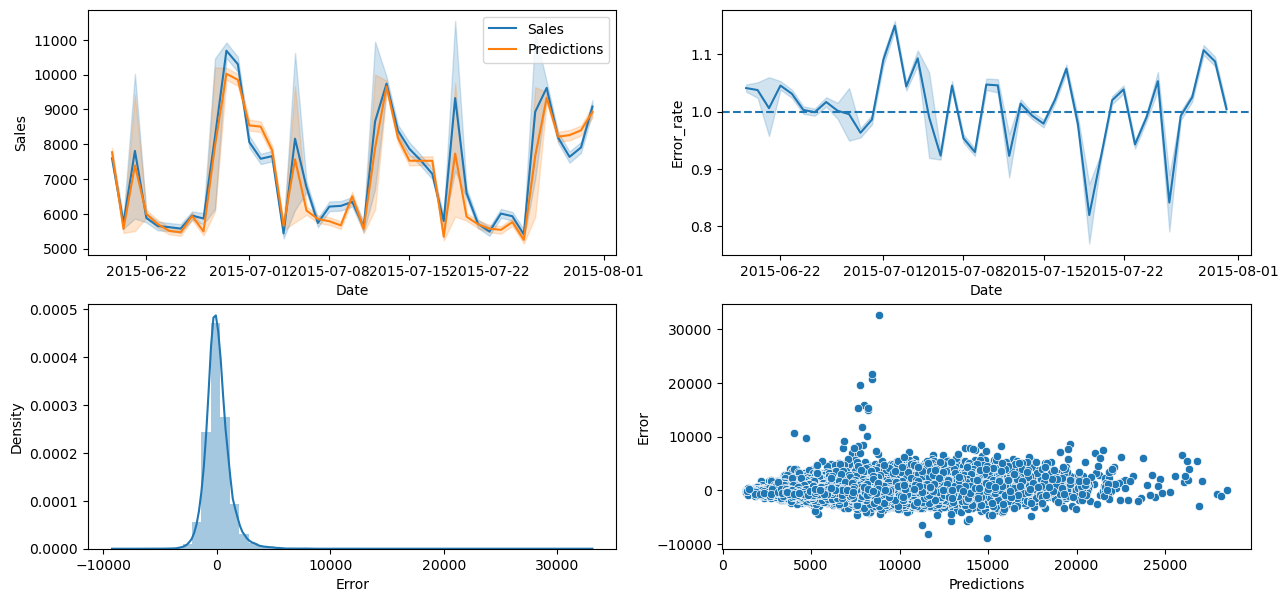

In [101]:
plt.figure(figsize = [15, 7])

plt.subplot( 2, 2, 1 )
sns.lineplot( x='Date', y='Sales', data=df9, label='Sales' )
sns.lineplot( x='Date', y='Predictions', data=df9, label='Predictions' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='Date', y='Error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['Error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot(x = df9['Predictions'], y = df9['Error'] );

# 10. DEPLOYMENT

## 10.1. Rossmann Class

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import datetime
import pickle



class Rossmann():
    def __init__(self):
        self.path = r'C:/Users/Noudy/Desktop/Estudo/rossmann-sales'
        self.StoreType_encoding = pickle.load(open(self.path + '/parameter/StoreType_encoding.pkl', 'rb'))
        self.CompetitionDistance_scaling = pickle.load(open(self.path + '/parameter/CompetitionDistance_scaling.pkl', 'rb'))
        self.CompetitionDuration_scaling = pickle.load(open(self.path + '/parameter/CompetitionDuration_scaling.pkl', 'rb'))
        self.PromoDuration_scaling = pickle.load(open(self.path + '/parameter/PromoDuration_scaling.pkl', 'rb'))
        self.Year_scaling = pickle.load(open(self.path + '/parameter/Year_scaling.pkl', 'rb'))
    
    def data_cleaning(self, df1):
        
        df1.columns = ['Store', 'DayOfWeek', 'Date', 
                       'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                       'StoreType', 'Assortment', 'CompetitionDistance',
                       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                       'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 
                       'PromoInterval'                                         ]

       
        ##  Data Types
        df1['Date'] = pd.to_datetime(df1['Date'])
        
 
        ## Fillout NA

        # CompetitionDistance    
        df1['CompetitionDistance'] = df1['CompetitionDistance'].fillna(250000)

        # CompetitionOpenSinceMonth 
        df1['CompetitionOpenSinceMonth'] = df1.apply(lambda x: x['Date'].month if np.isnan(x['CompetitionOpenSinceMonth']) else x['CompetitionOpenSinceMonth'], axis = 1)

        # CompetitionOpenSinceYear   
        df1['CompetitionOpenSinceYear'] = df1.apply(lambda x: x['Date'].year if np.isnan(x['CompetitionOpenSinceYear']) else x['CompetitionOpenSinceYear'], axis = 1)

        # Promo2SinceWeek      
        df1['Promo2SinceWeek'] = df1.apply(lambda x: x['Date'].weekofyear if np.isnan(x['Promo2SinceWeek']) else x['Promo2SinceWeek'], axis = 1)

        # Promo2SinceYear              
        df1['Promo2SinceYear'] = df1.apply(lambda x: x['Date'].year if np.isnan(x['Promo2SinceYear']) else x['Promo2SinceYear'], axis = 1)

        # PromoInterval                
        df1['PromoInterval'] = df1['PromoInterval'].fillna(0)

        ## Change Data Types

        # CompetitionOpenSinceMonth  
        df1['CompetitionOpenSinceMonth'] = df1['CompetitionOpenSinceMonth'].astype(np.int64)

        # CompetitionOpenSinceYear            
        df1['CompetitionOpenSinceYear'] = df1['CompetitionOpenSinceYear'].astype(np.int64)

        # Promo2SinceWeek                   
        df1['Promo2SinceWeek'] = df1['Promo2SinceWeek'].astype(np.int64)

        # Promo2SinceYear                   
        df1['Promo2SinceYear'] = df1['Promo2SinceYear'].astype(np.int64)


        MonthDict = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['MonthDict'] = df1['Date'].dt.month.map(MonthDict)

        df1['IsPromo'] = df1[['PromoInterval', 'MonthDict']].apply(lambda x: 0 if x['PromoInterval'] == 0 else 1 if x['MonthDict'] in x['PromoInterval'].split(',') else 0, axis=1)

        df1['StateHoliday'] = df1['StateHoliday'].apply(lambda x: 0 if x == '0' else x)
        
        
        return df1
    
    
    def feature_engineering(self, df2):
        
        # DateTimes
        df2['Day'] = df2['Date'].dt.day
        df2['Month'] = df2['Date'].dt.month
        df2['Year'] = df2['Date'].dt.year
        df2['WeekOfYear'] = df2['Date'].dt.weekofyear

        df2['CompetitionSince'] = df2.apply(lambda x: datetime.datetime(year = x['CompetitionOpenSinceYear'], month = x['CompetitionOpenSinceMonth'], day = 1), axis = 1)
        df2["CompetitionDurationMonth"] = df2.apply(lambda x: (x['Date'] - x['CompetitionSince'])/30, axis = 1).apply(lambda x: x.days)

        df2['PromoSince'] = df2.apply(lambda x: datetime.date.fromisocalendar(x['Promo2SinceYear'], x['Promo2SinceWeek'], 1), axis = 1)
        df2['PromoSince'] = pd.to_datetime(df2['PromoSince'])
        df2['PromoDurationWeek'] = df2.apply(lambda x: (x["Date"] - x['PromoSince']) / 7, axis = 1).apply(lambda x: x.days)

        # State Holiday
        holidays_dict = {'a': 'Public', 'b': 'Easter', 'c': 'Christmas', 0: 'Regular'}
        df2['StateHoliday'] = df2['StateHoliday'].map(holidays_dict)

        # Assortment
        assortment_dict = {'a': 'Basic', 'b': 'Extra', 'c': 'Extended'}
        df2['Assortment'] = df2['Assortment'].map(assortment_dict)
    
        df2 = df2[df2["Open"] == 1]

        ## Columns Filtering

        cols2drop = ['MonthDict', 'PromoInterval', 'Open']
        df2.drop(cols2drop, axis = 1, inplace = True)
        
        return df2
    
    
    def data_preparation(self, df5):
        
        # StateHoliday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['StateHoliday'], columns=['StateHoliday'])

        # StoreType - Label Encoding
        le = self.StoreType_encoding
        df5['StoreType'] = le.transform(df5['StoreType'])


        # Assortment - Ordinal Encoding
        assortment_dict = {'Basic': 1, 'Extra': 2, 'Extended': 3}
        df5['Assortment'] = df5['Assortment'].map( assortment_dict)


        ### Nature Transformation

        # Day Of Week
        df5['DayOfWeek_sin'] = df5['DayOfWeek'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['DayOfWeek_cos'] = df5['DayOfWeek'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # Month
        df5['Month_sin'] = df5['Month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['Month_cos'] = df5['Month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # Day
        df5['Day_sin'] = df5['Day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['Day_cos'] = df5['Day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # Week Of Year
        df5['WeekOfYear_sin'] = df5['WeekOfYear'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['WeekOfYear_cos'] = df5['WeekOfYear'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


        ## Scaling

        # Competition Distance
        rs = self.CompetitionDistance_scaling
        df5['CompetitionDistance'] = rs.transform(df5[['CompetitionDistance']].values)


        # Competition Duration Month
        rs = self.CompetitionDuration_scaling
        df5['CompetitionDurationMonth'] = rs.transform(df5[['CompetitionDurationMonth']].values)


        # Promo Duration Week
        mms = self.PromoDuration_scaling
        df5['PromoDurationWeek'] = mms.transform(df5[['PromoDurationWeek']].values)


        # Year
        mms = self.Year_scaling
        df5['Year'] = mms.transform(df5[['Year']].values)
        
        cols_selected = ['Store', 'Promo', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                         'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionDurationMonth',
                         'PromoDurationWeek', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos',
                         'WeekOfYear_sin', 'WeekOfYear_cos']
        
        df5 = df5[cols_selected]
        
        return df5
    
    
    def get_prediction(self, model, raw_data, test_data):
        
        print(test_data.dtypes)
        
        pred = model.predict(test_data)
        
        raw_data['Predictions'] = np.expm1(pred)
        
        return raw_data.to_json(orient = 'records', date_format = 'iso')

## 10.2. API Handler

In [ ]:
# -*- coding: utf-8 -*-
import pickle
import pandas as pd
from flask import Flask, request, Response
from classes.pipeline import Rossmann

model = pickle.load(open(r'C:\Users\Noudy\Desktop\Estudo\rossmann-sales\models\final_model.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
   
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
    
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        df1 = pipeline.data_cleaning( test_raw )
        df2 = pipeline.feature_engineering( df1 )
        df3 = pipeline.data_preparation( df2 )
    
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    else:    
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run('127.0.0.1')


## 10.3. API Tester

In [ ]:
kaggle.competition_download_file('rossmann-store-sales', 'test.csv');

with ZipFile('test.csv.zip', 'r') as Zip:
    Zip.extractall()
    
df10_test = pd.read_csv('test.csv')

remove('test.csv')
remove('test.csv.zip')

In [ ]:
df10 = df10_test.merge(df_store_raw, how = 'left', on = 'Store')
df10 = df10[df10['Open'] == 1]
df10.drop('Id', axis = 1, inplace = True)
df10 = df10[df10['Store'].isin( [1, 22, 31] )]
df10 = json.dumps(df10.to_dict(orient='records'))

In [ ]:
url = 'http://127.0.0.1:5000/rossmann/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data = df10, headers = header)
print('Status: {}'.format(r.status_code))

In [94]:
df10_pred = pd.DataFrame(r.json())
df10_pred[['Store', 'Predictions']].groupby('Store').sum().reset_index()

,Store,Predictions
0,1,182138.365723
1,22,189150.101318
2,31,239742.007813
